### Introduction 

When can either:
1. emphazise declared features in loss criterion

By emphazising weights to MSE we can emphazise more on certain features.
This may help to take individual requirements more into account e.g. a coach wants a player like Rodri especially like certain attributes.
In this case chapter we emphazise on 'Receiving_Succ', 'Shots'.

2. add more importance by multiplying the inpute features by some weights

### Load data

In [26]:
import pandas as pd 
import utils

# Set seed for reproducibility
SEED = 42

df, player_info = utils.load_player_statistics()

### 1. Emphazise in loss criterion

#### Scale data

In [28]:
from sklearn.preprocessing import StandardScaler, Normalizer

# scale data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#### Set up dataloader

In [29]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# Convert to PyTorch tensors
data_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(data_tensor, data_tensor)  # Input and target are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#### Define criterion

##### Delcare features

In [41]:
player_info_cols = ['Season', 'League', 'Team', 'Player', 'Nation', 'Pos','Global Pos', 'Age','Matches Played','Playing Time_Starts','Playing Time_Min','Playing Time_90s']

def_cols = ['Tackles_Att', 'Tackles_Def 3rd', 'Tackles_Mid 3rd',
        'Tackles_Att 3rd','Interceptions', 'Clearances','Errors',
        'Dribblers_Tkl_Succ','Dribblers_Tkl_Att','Dribblers_Tkl_Lost',
        'Blocks_Total', 'Blocks_Shots',
        ]

possession_cols = ['Touches_Number', 'Touches_Def Pen', 'Touches_Def 3rd',
       'Touches_Mid 3rd', 'Touches_Att 3rd', 'Touches_Att Pen','Take-Ons_Att', 'Take-Ons_Succ',
       'Take-Ons_Tkld','Take-Ons_Tkld%','Carries_Number', 'Carries_TotDist',
       'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3', 'Carries_CPA',
       'Carries_Mis', 'Carries_Dis','Receiving_Succ', 'Receiving_PrgR'
        ]
passing_cols = ['Total_Cmp', 'Total_Att', 'Total_Cmp%', 'Total_TotDist',
       'Total_PrgDist','Short_Cmp', 'Short_Att', 'Short_Cmp%', 'Medium_Cmp',
       'Medium_Att', 'Medium_Cmp%', 'Long_Cmp', 'Long_Att', 'Long_Cmp%','Assists', 'Key Passes', 'Passes_to_1/3',
       'Passes_to_Penalt_Area', 'Crosses_into_Penalty_Area','Progressive Passes']

gsc_cols = ['SCA', 'SCA90', 'SCA Types_PassLive', 'SCA Types_PassDead',
       'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld', 'SCA Types_Def', 'GCA',
       'GCA90', 'GCA Types_PassLive', 'GCA Types_PassDead', 'GCA Types_TO',
       'GCA Types_Sh', 'GCA Types_Fld', 'GCA Types_Def'
        ]

shooting_cols = ['Goals', 'Shots', 'SoT', 'SoT%', 'Shots/90','Goals/Shot', 'Goals/SoT']

adv_goalkeeping = ['Goals_GA', 'Goals_PKA', 'Goals_FK', 'Goals_CK', 'Goals_OG', 'PSxG',
       'PSxG/SoT', 'PSxG+/-', '/90', 'Launched_Cmp', 'Launched_Att',
       'Launched_Cmp%', 'Passes_Att', 'Passes_Thr', 'Passes_Launch%',
       'Passes_AvgLen', 'Goal Kicks_Att', 'Goal Kicks_Launch%',
       'Goal Kicks_AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90',
       'AvgDist']
goalkeeping_cols = ['GA',
       'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L', 'CS', 'CS%',
       'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKsv',
       'Penalty Kicks_PKm', 'Penalty Kicks_Save%']


misc_cols = ['2CrdY', 'Fls', 'Fld', 'Off', 'Crs','PKwon', 
            'PKcon', 'OG', 'Recov', 'Aerial Duels_Won',
            'Aerial Duels_Lost'
        ]



playing_time_cols = ['Playing Time_Minutes', 'Playing Time_Mn/MP','Starts', 'Mn/Start', 'Compl',
                     'Subs', 'unSub', 'PPM','onG', 'onGA','On-Off'
                    ]

feature_vector = (player_info_cols + def_cols + possession_cols + passing_cols + 
               gsc_cols + shooting_cols + adv_goalkeeping + goalkeeping_cols + 
               misc_cols + playing_time_cols)

In [30]:
# focus on carry dimension
weight_dimension= ['Carries_TotDist', 'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3']
start_idx, end_idx = utils.get_feature_indices(df, weight_dimension)

def add_weights_to_feature(start_idx, end_idx, df):
    feature_weights = [1] * df.shape[1]

    for i in range(start_idx, end_idx + 1):
        feature_weights[i] =  2.0
    
    return feature_weights

features_weights = add_weights_to_feature(start_idx,end_idx,df)

##### weighted criterion

In [31]:
import torch.nn as nn

class WeightedMSELoss(nn.Module):
    def __init__(self, feature_weights):
        super(WeightedMSELoss, self).__init__()
        self.feature_weights = torch.tensor(feature_weights, dtype=torch.float32)
    
    def forward(self, output, target):
        # Compute the MSE loss
        mse_loss = nn.MSELoss(reduction='none')(output, target)
        # Apply the feature weights
        weighted_loss = mse_loss * self.feature_weights
        # Return the mean of the weighted losses
        return weighted_loss.mean()

# Instantiate the custom loss function
weighted_criterion = WeightedMSELoss(features_weights)

#### Create model

In [32]:
import autoencoder
import torch.optim as optim

# Define model parameters
input_dim = df_scaled.shape[1]  # Input dimensions = number of features
encoding_dim = 50  # Size of the bottleneck layer

# Create model
model = autoencoder.Autoencoder(input_dim, encoding_dim)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Training

In [33]:
model = autoencoder.train_model(
    model=model,
    dataloader=dataloader,
    criterion=weighted_criterion,
    optimizer=optimizer,
    num_epochs=50
)

Epoch [10/50], Loss: 1.9781
Epoch [20/50], Loss: 1.8354
Epoch [30/50], Loss: 0.4829
Epoch [40/50], Loss: 0.3514
Epoch [50/50], Loss: 0.2786


#### Bottleneck Layer - latent vector - embeddings

In [34]:
# Pushing whole data set through network to get latent vector
embeddings = model.get_embeddings(data_tensor)

#### Top k Similar Players - cosine

In [35]:
top_k_similar_players_cosine = utils.get_top_k_similar_players(
    embeddings=embeddings,
    query_index=795,
    player_info=player_info,
    top_k=10
)

top_k_similar_players_cosine

,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,cosine_similarity
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,1.000000
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,0.979820
Rafa Silva,2022-2023,PrimeiraLiga,Benfica,Rafa Silva,POR,"MF,FW",MF,29.0,28.0,26.0,2174.0,24.2,0.967457
Folarin Balogun,2022-2023,Ligue1,Reims,Folarin Balogun,USA,FW,FW,21.0,37.0,34.0,2999.0,33.3,0.964457
Burak Yılmaz,2022-2023,EreDivisie,Fortuna Sittard,Burak Yılmaz,TUR,FW,FW,37.0,26.0,24.0,2218.0,24.6,0.963355
Karim Benzema,2022-2023,LaLiga,Real Madrid,Karim Benzema,FRA,FW,FW,34.0,24.0,24.0,2038.0,22.6,0.962426
Alexis Sánchez,2022-2023,Ligue1,Marseille,Alexis Sánchez,CHI,"FW,MF",FW,33.0,35.0,32.0,2679.0,29.8,0.961896
Danny Welbeck,2022-2023,EPL,Brighton,Danny Welbeck,ENG,FW,FW,31.0,31.0,21.0,1854.0,20.6,0.956768
Randal Kolo Muani,2022-2023,Bundesliga,Eint Frankfurt,Randal Kolo Muani,FRA,FW,FW,23.0,32.0,31.0,2631.0,29.2,0.954168


#### Top k Similar Players - euclidean

In [36]:
top_k_similar_players_euclidean = utils.get_top_k_similar_players(
    embeddings=embeddings,
    query_index=795,
    player_info=player_info,
    top_k=10,
    distance_metric='euclidean'
)

top_k_similar_players_euclidean

,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,euclidean_distance
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,0.000000
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,6.658888
Karim Benzema,2022-2023,LaLiga,Real Madrid,Karim Benzema,FRA,FW,FW,34.0,24.0,24.0,2038.0,22.6,8.749896
Jonathan Ikone,2022-2023,SeriaA,Fiorentina,Jonathan Ikone,FRA,FW,FW,24.0,33.0,24.0,2007.0,22.3,9.977515
Tammy Abraham,2022-2023,SeriaA,Roma,Tammy Abraham,ENG,FW,FW,24.0,38.0,24.0,2189.0,24.3,10.165544
Rasmus Højlund,2022-2023,SeriaA,Atalanta,Rasmus Højlund,DEN,FW,FW,19.0,32.0,20.0,1834.0,20.4,10.540055
Andrej Kramarić,2022-2023,Bundesliga,Hoffenheim,Andrej Kramarić,CRO,"MF,FW",MF,31.0,32.0,26.0,2386.0,26.5,10.605616
Ademola Lookman,2022-2023,SeriaA,Atalanta,Ademola Lookman,NGA,"FW,MF",FW,24.0,31.0,20.0,1729.0,19.2,10.644508
Dany Mota,2022-2023,SeriaA,Monza,Dany Mota,POR,"FW,MF",FW,24.0,29.0,21.0,1912.0,21.2,10.648795


#### emphasized features
cosine

In [43]:
top_k_similar_players_features_cosine = utils.get_top_k_similar_players(
    embeddings=embeddings,
    query_index=795,
    player_info=df,
    top_k=30
)
df_emphasized_features_cosine = top_k_similar_players_features_cosine[weight_dimension]
df_emphasized_features_cosine.head()

,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3
Player,,,,
Christopher Nkunku,2929.0,1225.0,43.0,23.0
Ciro Immobile,2914.0,1134.0,40.0,21.0
Rafa Silva,5507.0,2749.0,99.0,65.0
Folarin Balogun,4561.0,1697.0,56.0,27.0
Burak Yılmaz,2377.0,940.0,36.0,25.0


euclidean

In [38]:
top_k_similar_players_features_euclidean = utils.get_top_k_similar_players(
    embeddings=embeddings,
    query_index=795,
    player_info=df,
    top_k=30,
    distance_metric='euclidean'
)
df_emphasized_features_euclidean = top_k_similar_players_features_euclidean[weight_dimension]
df_emphasized_features_euclidean.head()


,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3
Player,,,,
Christopher Nkunku,2929.0,1225.0,43.0,23.0
Ciro Immobile,2914.0,1134.0,40.0,21.0
Karim Benzema,3734.0,1900.0,72.0,43.0
Jonathan Ikone,5072.0,2366.0,83.0,45.0
Tammy Abraham,2154.0,856.0,35.0,20.0


#### Visualize emphasized feauteres

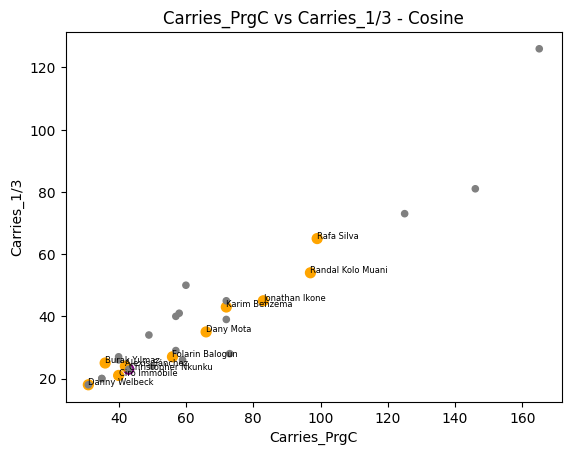

In [39]:
import utils
utils.scatterplot_top_k(df_emphasized_features_cosine, 'Carries_PrgC', 'Carries_1/3', 
                        num_labels=10, top_size=50, rest_size=20, fontsize=6,
                        dist_measure='Cosine')

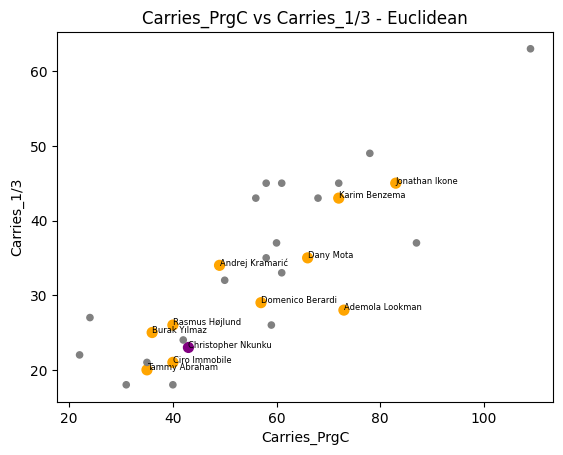

In [40]:
utils.scatterplot_top_k(df_emphasized_features_euclidean, 'Carries_PrgC', 'Carries_1/3', 
                        num_labels=10, top_size=50, rest_size=20, fontsize=6,
                        dist_measure='Euclidean')